# Тематическое моделирование

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import joblib
import pickle
from wordcloud import WordCloud

import nltk
from gensim import corpora, models, utils
from bs4 import BeautifulSoup

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from scipy.spatial.distance import cosine


## Подготовим данные для Тематического моделирования

In [52]:
# Загрузим данные полученные на предыдущем шаге:

vectors_data = pd.read_csv('vectors_data.csv')
vectors_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
vectors_data


,angularjs,bootstrap,базы данных,mssql,html5,css3,js,ajax,websocket,csharp,...,отчеты,анализ требований,html css,github,communication skills,код ревью,dry,microsoft,mobile,внимательность
0,0,1,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1224,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1225,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1227,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# Переведем все вакансии в списки навыков:
lists_for_topic = []

for index, row in vectors_data.iterrows():
    one_vacancy = []
    columns_key = vectors_data.columns.tolist()
    for i in range(len(row)):
        if row[i] == 1:
            one_vacancy.append(columns_key[i])
    lists_for_topic.append(one_vacancy)
len(lists_for_topic)


1229

In [174]:
lists_for_topic[1]


['bootstrap',
 'js',
 'react',
 'angular',
 'vuejs',
 'oop',
 'css',
 'es6',
 'desktop']

In [55]:
data_vacances = pd.read_csv('data_vacances.csv')
data_vacances.drop(['Unnamed: 0'], axis = 1, inplace = True)
data_vacances


,index,name,skills,describe,url,salary_from,salary_to,salary_currency,salary_gross,salary_median,experience,employment
0,1,frontend разработчик,bootstrap html5 css3 js ajax websocket git vue...,компания эргосоло работает с 2002 года наш...,https://hh.ru/vacancy/36497379,120000.0,NaN,RUR,False,150000,middle,full
1,2,ведущий frontend разработчик,bootstrap js react angular vuejs oop css es6 s...,verme уже более 6 лет является экспертом wfm ...,https://hh.ru/vacancy/35493020,150000.0,NaN,RUR,False,187500,senior,full
2,3,full stack разработчик net csharp,mssql csharp net wpf рефакторинг умение работа...,региональное представительство компании quipu...,https://hh.ru/vacancy/36741295,1800.0,NaN,EUR,False,180000,middle,full
3,4,frontend разработчик,react webpack redux typescript api ux saga sty...,расширяем команду и ищемjs разработчика с ш...,https://hh.ru/vacancy/36676120,220000.0,260000.0,RUR,False,240000,senior,full
4,5,frontend разработчик,angularjs react less git sass angular scss spa...,приглашаем front end разработчика с опытом от...,https://hh.ru/vacancy/36669665,NaN,60000.0,RUR,True,48000,middle,full
...,...,...,...,...,...,...,...,...,...,...,...,...
1224,5922,ведущий java разработчик lead java developer,mssql rest kafka mysql sql java postgres docke...,в группу занимающуюся решением широкого круг...,https://hh.ru/vacancy/36730761,180000.0,250000.0,RUR,False,215000,senior,full
1225,5925,java developer voip,cplus agile rest java docker golang kubernetes...,наш клиент американская компания ooma разра...,https://hh.ru/vacancy/34313448,NaN,300000.0,RUR,False,240000,senior,full
1226,5926,программист bitrix bitrix24,less oop php jquery css sql html 1c bitrix jso...,задачи разработка и поддержка веб сайтов на...,https://hh.ru/vacancy/36718950,60000.0,110000.0,RUR,False,85000,senior,full
1227,5928,разработчик на java senior москва,базы данных react nodejs gulp webpack java pos...,привет я саша cto в driverpack у нас неболь...,https://hh.ru/vacancy/36532390,NaN,300000.0,RUR,False,240000,senior,full


In [56]:
erratum = {

    'f #': 'fsharp',
    '#f': 'fsharp',
    'f#': 'fsharp',
    'c #': 'csharp',
    'с#': 'csharp',
    'c#': 'csharp',
    'c ++': 'cplus',
    'с++': 'cplus',
    'c c++': 'cplus',
    'с c++': 'cplus',
    'с/c++': 'cplus',
    'c/c++': 'cplus',
    'c++': 'cplus',
    'r#': 'rsharp',
    'java,': 'java',
    'qa engineer': 'qa',
    'javascript': 'js',
    'spring framework': 'spring',
    'ооп': 'oop',
    'субд': 'sql',
    'знание js': 'js',
    ' js': 'js',
    '.js': 'js',
    ' го ': 'go',
    '1с': '1c',
    '.net framework': '.net',
    'postgresql': 'postgres', 
    'игры': 'games',
    'тестировщик': 'тестирование',
    'english': 'английский язык',
    'ms sql server': 'sql server',
    'data scient': 'data science',
    'data scientist': 'data science',
    'data scienceist': 'data science',
    'data science': 'ds',
    'machine learning': 'ml',
    'битрикс': 'bitrix',
    '1c bitrix': 'bitrix',
    'spark,': 'spark',
    'mongodb': 'mongo', 
    'scikit-learn': 'sklearn',
    'scikit learn': 'sklearn',
    'scikit': 'sklearn',
    'django framework': 'django',
    'анализ данных': 'data analysis',
    'elasticsearch': 'elastic',
    'unreal engine':'unreal',
    'yii':'ii',
    '.net csharp': 'net csharp',
    '.net core': 'net core',
    'nestjs': 'nest',
    'matlab simulink': 'simulink',
    'sql (percona)': 'percona',
    'ibm datastage': 'datastage',
    'raspberry pi': 'raspberry',
    'rabbitmq': 'rabbit',
    'scada': 'scad',
    'automation engineer': 'qa automation',
    'adobe indesign': 'indesign',
    'qlik': 'qli',
    'google data studio': 'data studio',
    'salesforce.com': 'force.com',
    'dpdk': 'pdk',
    'bigdata': 'big data',
    'ms sql': 'mssql',
    'transact-sql': 't-sql',
    'reverse engineering': 'reverse',
    'docker swarm': 'swarm', 
    'entity framework': 'entity',
    'unreal 4': 'unreal',
    '1c: предприятие 8': '1c предприятие',
    'dagger 2': 'dagger',
    'hdfs': 'hadoop',
    'rest api': 'rest',
    'restful api': 'restful',
    'тестирование по': 'тестирование', 
    'знание git': 'git',
}


def cleaned_text(text):
    j = text.lower()
    
    for i in erratum:
        if i in j:
            while i in j:
                j = j.replace(i, erratum[i])
    rep = re.compile("[^a-zA-Zа-яА-я\d]")
    j = rep.sub(" ", j)
    return j


# Обучим тематическую модель LdaModel

Создадим словать и корпус. 

Для модели подобрал следующие входны параметры: 

количество тем = 65, 

no_below - берем лишь слова, которые встречаются более чем в 7 вакансиях

no_above - берем лишь слова, которые встречаются в менее чем в 25% вакансий


In [369]:
num_topics = 65
dictionary = corpora.Dictionary(lists_for_topic)
dictionary.filter_extremes(no_below = 7, no_above = 0.25)
corpus = [dictionary.doc2bow(text) for text in lists_for_topic]


In [370]:
%%time

# Обучаем нашу модель:
ldamodel = models.ldamodel.LdaModel(
    corpus = corpus,
    id2word = dictionary,
    num_topics = num_topics,
    passes = 30,
)


CPU times: user 43.5 s, sys: 158 ms, total: 43.6 s
Wall time: 43.7 s


In [389]:
# Сохраняем модель в файл:
ldamodel.save("ldamodel_65_base")


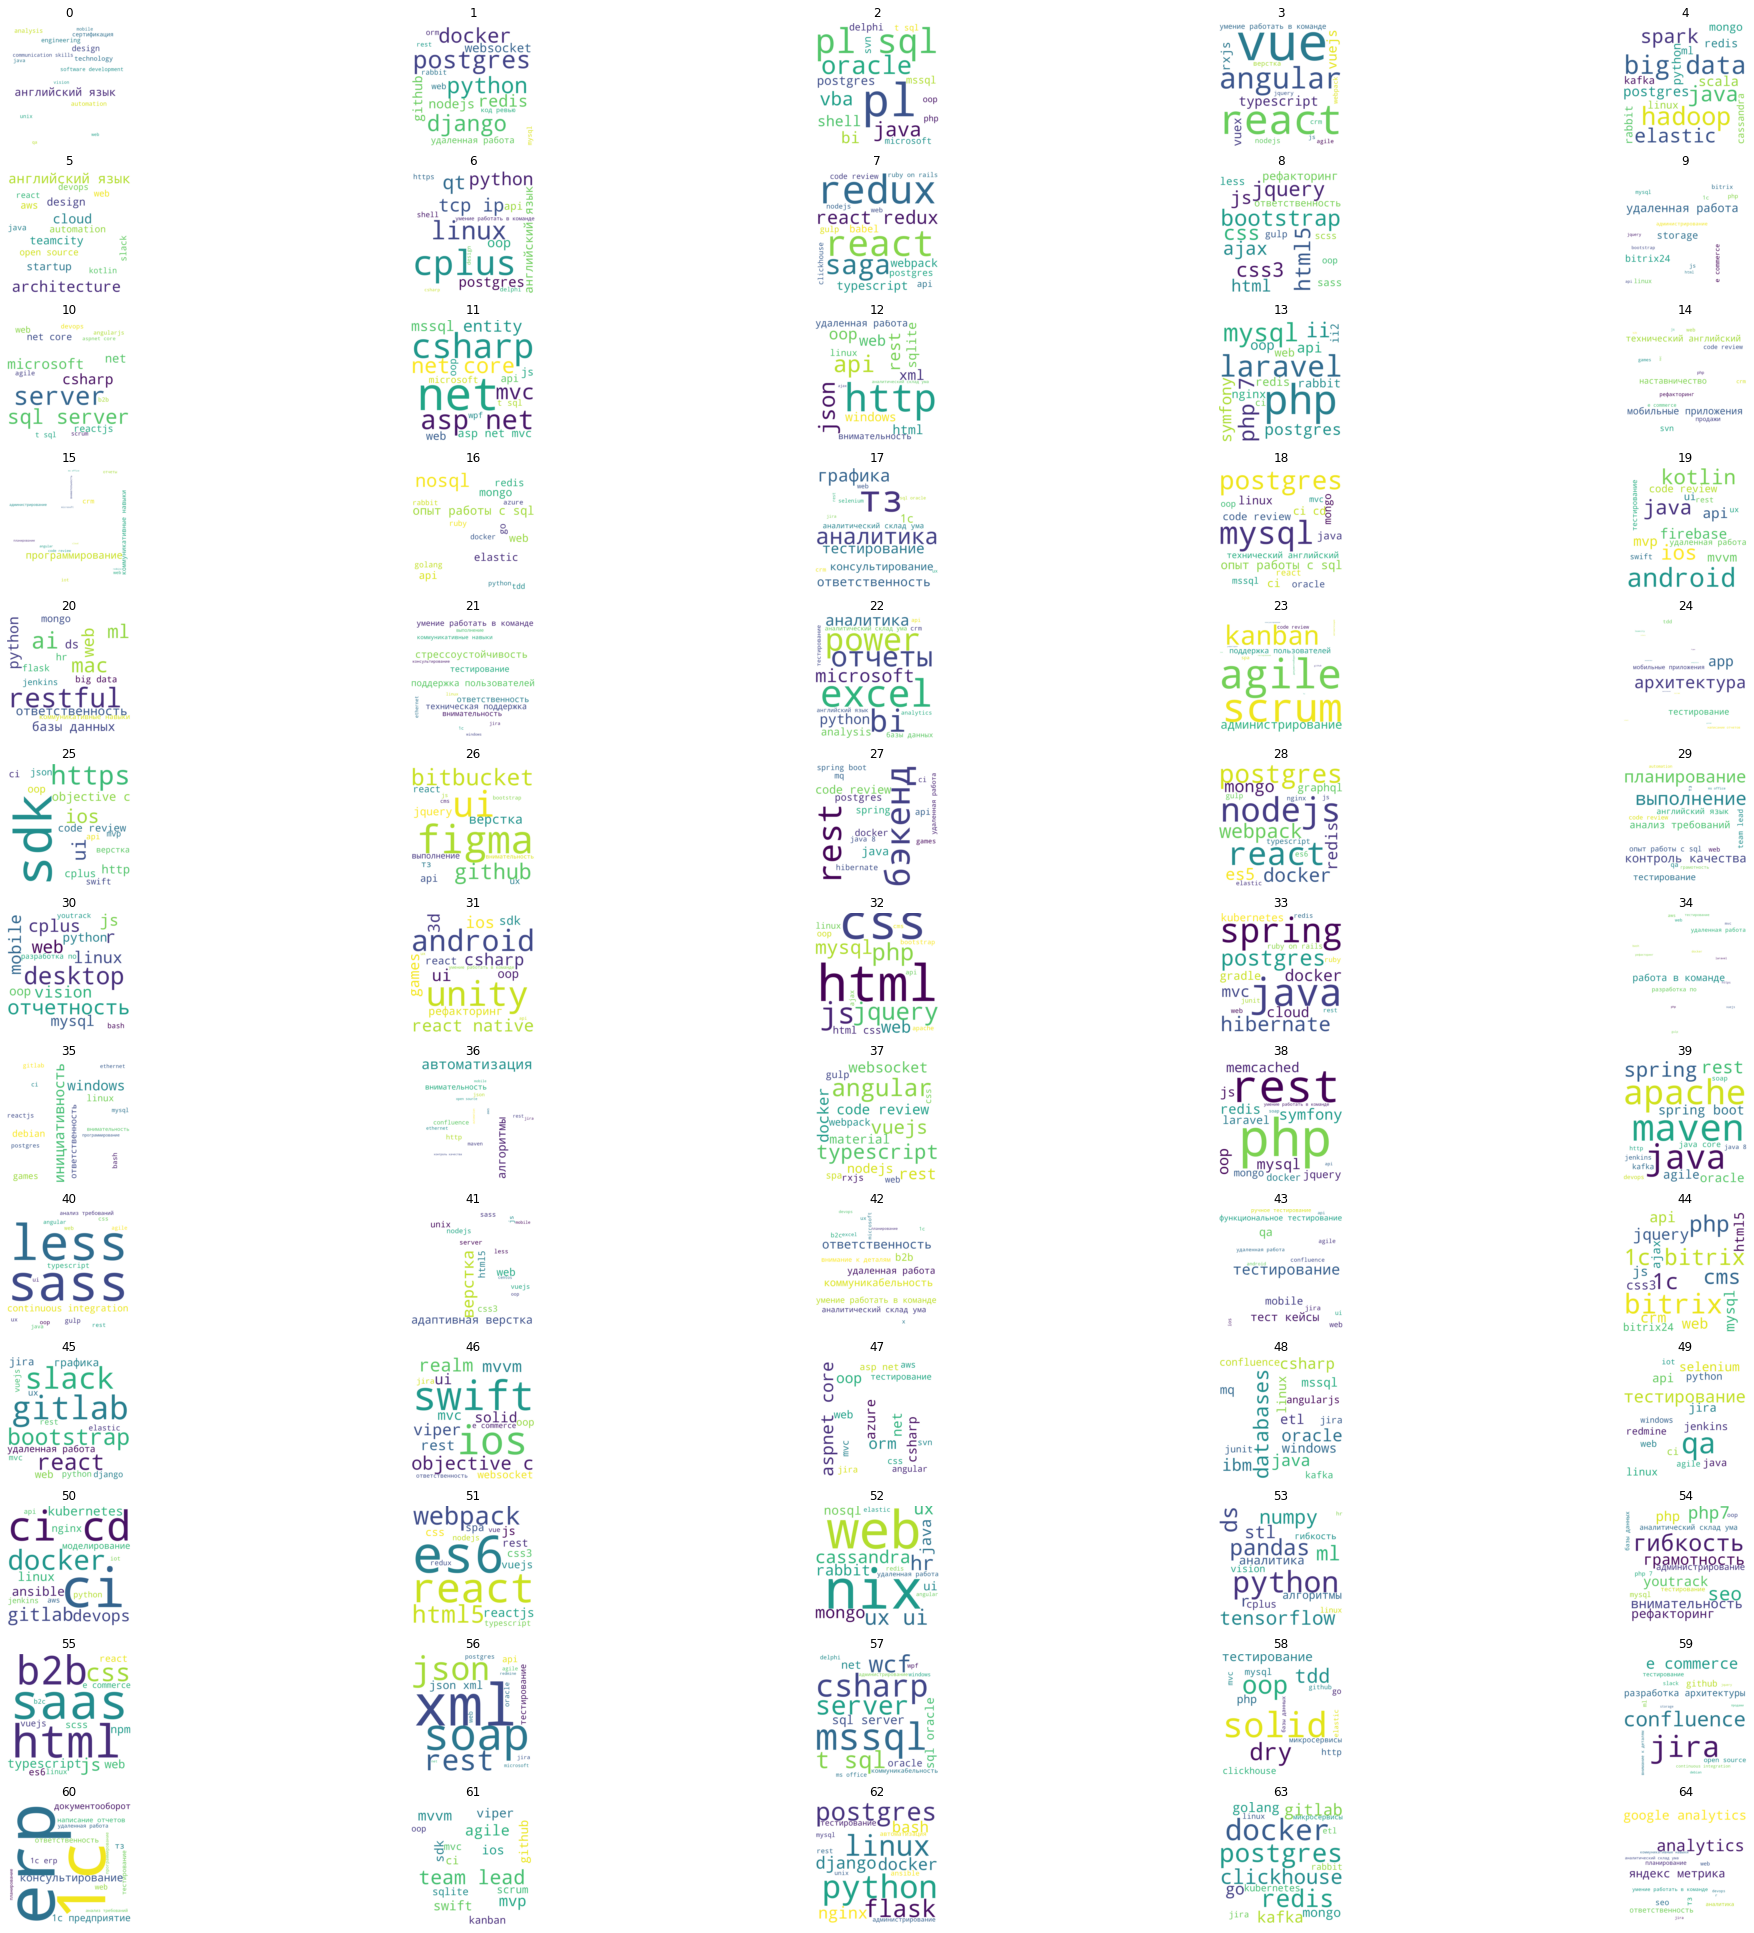

In [372]:
# Визуализируем распределение слов наших тем (топиков):
topics = ldamodel.show_topics(num_topics = num_topics, num_words = 15, formatted = False)

fig, axs = plt.subplots(int(num_topics / 5), 5, figsize = (35, 35))

j = 0
for i in range(num_topics):
    ax = axs[j // 5, j % 5]
    
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 20,
        width = 900,
        height = 900,
        collocations = False
    )
    
    text = dict(topics[i][1])
    wordcloud = wordcloud.generate_from_frequencies(text)
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.axis('off')
    ax.set(title = i)
    j += 1


In [373]:
# Тоже самое в текстовом представлении
ldamodel.show_topics(num_topics = num_topics, num_words = 15, formatted = False)


[(0,
  [('английский язык', 0.24269906),
   ('design', 0.09670103),
   ('technology', 0.062609956),
   ('analysis', 0.05433971),
   ('automation', 0.053307686),
   ('engineering', 0.053065408),
   ('сертификация', 0.047341406),
   ('software development', 0.039354406),
   ('unix', 0.03889959),
   ('communication skills', 0.037719477),
   ('java', 0.035933394),
   ('mobile', 0.029015735),
   ('qa', 0.02810771),
   ('web', 0.027179848),
   ('vision', 0.026718087)]),
 (1,
  [('postgres', 0.13388446),
   ('python', 0.11098818),
   ('django', 0.11008102),
   ('docker', 0.09159917),
   ('redis', 0.057533912),
   ('nodejs', 0.045493364),
   ('github', 0.04498126),
   ('websocket', 0.04415708),
   ('удаленная работа', 0.041157812),
   ('web', 0.036510084),
   ('orm', 0.029611459),
   ('rabbit', 0.026740456),
   ('rest', 0.022294028),
   ('код ревью', 0.021928934),
   ('mysql', 0.021904293)]),
 (2,
  [('pl', 0.18740095),
   ('pl sql', 0.16160813),
   ('oracle', 0.16046864),
   ('java', 0.096428

# Построим предсказание

## Предскажем номер преобладающей темы

In [374]:
# функция предсказания номера преобладающей темы для вакансии:
def get_top_topic(my_vacancy):
    
    doc = [cleaned_text(i) for i in my_vacancy]
    new_vec = dictionary.doc2bow(doc)
    perl = ldamodel.get_document_topics(new_vec)
    row = perl[0] if ldamodel.per_word_topics else perl            
    row = sorted(row, key = lambda x: (x[1]), reverse = True)
    topic_numer = row[0][0]

    return (topic_numer)


In [375]:
# Посмотрим на пример определения темы для вакансии:

my_vacancy = ['python', 'numpy', 'pandas', 'matplotlib', 'sklearn']
num_top = get_top_topic(my_vacancy)
num_top


53

In [376]:
# Посмотрим на ключевые слова в теме, к которой была отнесена наша вакансия:

topic_keywords = [word for word, prop in ldamodel.show_topic(num_top, topn = 15)]
topic_keywords


['python',
 'ds',
 'pandas',
 'ml',
 'numpy',
 'tensorflow',
 'stl',
 'r',
 'аналитика',
 'алгоритмы',
 'cplus',
 'vision',
 'гибкость',
 'linux',
 'hr']

In [377]:
# Предскажем для каждой нашей вакансии номер Темы:

list_topic_numbers_df = list()
for i in lists_for_topic:
    list_topic_numbers_df.append(get_top_topic(i))

len(list_topic_numbers_df)


1229

In [378]:
# Вставим номер темы в наш DataFrame:

data_vacances['topic_number'] = list_topic_numbers_df
data_vacances.head()


,index,name,skills,describe,url,salary_from,salary_to,salary_currency,salary_gross,salary_median,experience,employment,topic_number
0,1,frontend разработчик,bootstrap html5 css3 js ajax websocket git vue...,компания эргосоло работает с 2002 года наш...,https://hh.ru/vacancy/36497379,120000.0,NaN,RUR,False,150000,middle,full,8
1,2,ведущий frontend разработчик,bootstrap js react angular vuejs oop css es6 s...,verme уже более 6 лет является экспертом wfm ...,https://hh.ru/vacancy/35493020,150000.0,NaN,RUR,False,187500,senior,full,51
2,3,full stack разработчик net csharp,mssql csharp net wpf рефакторинг умение работа...,региональное представительство компании quipu...,https://hh.ru/vacancy/36741295,1800.0,NaN,EUR,False,180000,middle,full,11
3,4,frontend разработчик,react webpack redux typescript api ux saga sty...,расширяем команду и ищемjs разработчика с ш...,https://hh.ru/vacancy/36676120,220000.0,260000.0,RUR,False,240000,senior,full,7
4,5,frontend разработчик,angularjs react less git sass angular scss spa...,приглашаем front end разработчика с опытом от...,https://hh.ru/vacancy/36669665,NaN,60000.0,RUR,True,48000,middle,full,8


In [379]:
# Посмотрим вакансии, которые так же отнесены к теме нашего набора навыков из примера:

data_vacances[data_vacances['topic_number'] == num_top]


,index,name,skills,describe,url,salary_from,salary_to,salary_currency,salary_gross,salary_median,experience,employment,topic_number
87,147,программист cplus python,git python cplus рефакторинг mercurial opencv ...,обязанности разработка алгоритмов для инте...,https://hh.ru/vacancy/35909189,110000.0,NaN,RUR,False,137500,senior,full,53
147,262,разработчик cplus computer graphics comput...,qt cplus oop unreal unity android opengl windo...,кто мы пятый вид мультимедиа это научно п...,https://hh.ru/vacancy/36752503,120000.0,NaN,RUR,False,150000,senior,full,53
186,325,python разработчик администратор процессов ...,python автоматизация технический английский пр...,условия инвестиционная компания с 2005 года...,https://hh.ru/vacancy/36425758,80000.0,NaN,RUR,False,100000,senior,full,53
696,1966,quantitative researcher,английский язык python sklearn pandas numpy ma...,work with us qu ntport offers a supportive en...,https://hh.ru/vacancy/29014173,300000.0,NaN,RUR,True,375000,senior,full,53
852,3098,senior product data analyst,python sql saas планирование r статистика github,кто мы manychat это saas для автоматизации...,https://hh.ru/vacancy/31648507,150000.0,NaN,RUR,False,187500,senior,full,53
854,3109,nlp engineer ds nlp,python умение работать в команде ds коммуникат...,о компании компания была создана в 2012 году...,https://hh.ru/vacancy/36725244,100000.0,250000.0,RUR,False,175000,middle,full,53
855,3111,ds портфельный аналитик,python sql автоматизация ds аналитика,задачи построение скоринговых моделей для к...,https://hh.ru/vacancy/36552682,130000.0,NaN,RUR,False,162500,middle,full,53
856,3112,ds middle,python java scala ds ml удаленная работа spark...,в отдел аналитики процессов и потоков данных ...,https://hh.ru/vacancy/36626949,NaN,150000.0,RUR,False,120000,middle,full,53
858,3133,nlp analyst,английский язык python unix pandas numpy gensi...,work with us qu ntport offers a supportive en...,https://hh.ru/vacancy/35854943,250000.0,NaN,RUR,True,312500,middle,full,53
859,3142,junior quantitative researcher,английский язык python sklearn pandas numpy ma...,work with us qu ntport offers a supportive en...,https://hh.ru/vacancy/31844648,250000.0,250000.0,RUR,True,250000,middle,full,53


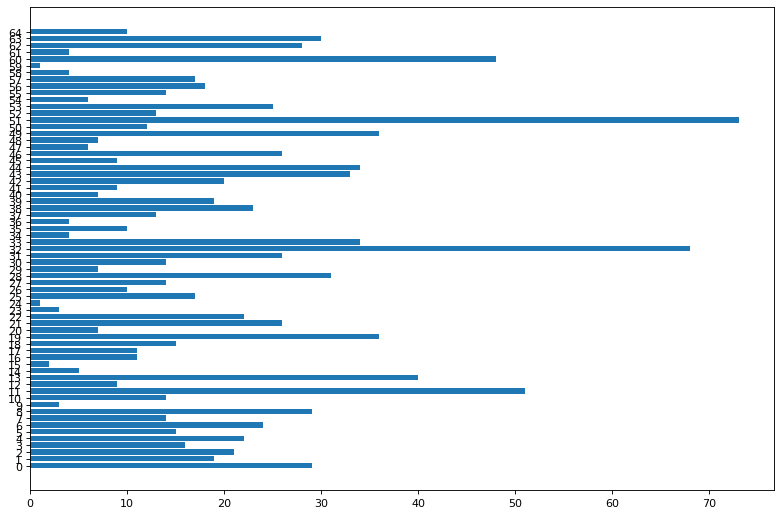

In [381]:
# Посмотрим на количество вакансий в каждой теме
data_sum = data_vacances['topic_number'].value_counts()
plt.figure(num = None, figsize = (12, 8), dpi = 80, facecolor = 'w', edgecolor = 'k')
plt.barh(data_sum.index, data_sum.values, height = 0.8, tick_label = data_sum.index);


Как видим на графике в каждой теме есть вакансии.

Есть 3 темы с количеством вакансий более 50.


# Построим прогноз

Замечания и описание функции прогноза:
1. Функция определяет к какой теме больше подходит входная вакансия
2. <b>Строим модель прогноа зарплаты</b> RandomForestRegressor с настройками по-умолчанию для прогноза зарплаты в зависимости от указанных навыков. Данные для обучения модели берутся именно из вакансий данной темы. А так как в каждой теме не более 100 вакансий, то уровень точности, особенно при оценки стоимости одного навыка не совсем корректны. Но для демонстрации работы идеи, думаю, сойдет)
3. <b>Прогнозируем зарплату</b> для нашей вакансии.
4. <b>Отбираем похожие признаки.</b> Близкими признаками мы считаем те, которые находятся в одной Теме с нашей вакансией.
5. <b>Расчитываем стоимость навыков</b> Проходим по всем навыкам из темы, к которой была отнесена наша вакансия. Добавляем ее в наш перечень и навыков и расчитываем прогнозную зарплату. Сравниваем ее с зарплатой нашей вакансии и как раз этой разнице будет равняться стоимость навыка. Выбираем навыки с наибольшей стоимостью.
6. <b>Подбираем подходящие вакансии для рекомендации.</b> На основе косинусного расстояния выбираем подходящие вакансии из одной, с нашей вакансией, Темы.


In [392]:
def get_recomend(my_vacancy_in):
    
    # Обработавыем нашу вакансию и переводим ее в вектор:
    my_vacancy = [cleaned_text(i) for i in my_vacancy_in]
    num_top = get_top_topic(my_vacancy)
    topic_keywords = [word for word, prop in ldamodel.show_topic(num_top, topn = 10)]
  
    # Подготавливаем данные для построения и собственно обучаем модель:
    topic_salares = data_vacances[data_vacances['topic_number'] == num_top]['salary_median'].tolist()
    indexs_skills = data_vacances[data_vacances['topic_number'] == num_top].index.tolist()
    vectors_salary = vectors_data.loc[indexs_skills, topic_keywords]
    rf_full = RandomForestRegressor(random_state = 4, n_jobs = -1)
    rf_full.fit(vectors_salary, topic_salares)

    
    # Это функция переводит нашу вакансию в вектор:
    def get_vector_vacancy(my_vacancy):
        my_vac_in_vec = []
        for i in topic_keywords:
            if i in my_vacancy: my_vac_in_vec.append(1)
            else: my_vac_in_vec.append(0) 
        my_vaca = pd.DataFrame(columns = topic_keywords)
        my_vaca.loc[1] = my_vac_in_vec
        
        return my_vaca
    
    my_vaca = get_vector_vacancy(my_vacancy)
    itog_salary = int(rf_full.predict(my_vaca)[0])
    
    # Создадим список навыков с их стоимостью:
    recomend_dict = {}
    for i in topic_keywords:
        if i not in my_vacancy:
            bb = my_vacancy.copy()
            bb.append(cleaned_text(i))
            bbb = get_vector_vacancy(bb)
            vr_salary = int(rf_full.predict(bbb)[0])
            if vr_salary > itog_salary:
                recomend_dict[i] = vr_salary - itog_salary
    
    # и отсортируем их:
    sort_recomend_dict = {}
    keys_l = []
    vals_l = []
    for k, v in recomend_dict.items():
        vals_l.append(v)
        keys_l.append(k)
    
    sort_index_rec = list(np.argsort(vals_l))
    sort_index_rec.reverse()
    for i in sort_index_rec: sort_recomend_dict[keys_l[i]] = vals_l[i]
    

    # Получим рекомендуемые вакансии:
    cosine_list = []
    ind_vac_rec = vectors_salary.index.tolist()
    my_vaca_vec = my_vaca.iloc[0].tolist()
    for i in ind_vac_rec:
        cos_r = cosine(my_vaca_vec, vectors_salary.loc[i].tolist())
        cosine_list.append(cos_r)
    cos_ind = list(np.argsort(cosine_list))
    cos_ind.reverse()
    list_recomend = [data_vacances.iloc[ind_vac_rec[i]] for i in cos_ind]


    # Вывод рекомендации:
    print('Ориентировочная зарплата: %s \n'% itog_salary)
    if sort_recomend_dict:
        for i in sort_recomend_dict:
            print ("Навык '%s' даст +%s р."% (i, sort_recomend_dict[i]))
    else: print('Вы достигли высот!')
    
    print('\n Подходящие вакансии:')
    for j in range(5):
        print('\nВакансия:', list_recomend[j]['name'])
        print('Требуемые навыки:', list_recomend[j]['skills'])
        print('Ссылка:', list_recomend[j]['url'])
        


Рекомендации не всегда идеальны, но в среднем получается что-то похожее на правду)

Это связано с малым количеством данных


### Посмотрим на рекомендации для некоторых наборов навыков

In [393]:
my_vacancy = ['python', 'ds', 'ml', 'numpy', 'pandas', 'matplotlib', 'sklearn']
get_recomend(my_vacancy)


Ориентировочная зарплата: 181345 

Навык 'алгоритмы' даст +13869 р.
Навык 'tensorflow' даст +9910 р.

 Подходящие вакансии:

Вакансия:  менеджер по аналитике  отдел целевого маркетинга  
Требуемые навыки: python sql sas big data vba аналитика r статистика spss modeler excel spss математика 
Ссылка: https://hh.ru/vacancy/36702012

Вакансия:  инженер разработчик 
Требуемые навыки: csharp python работа с базами данных api ms project программирование vba bim r r d revit api 
Ссылка: https://hh.ru/vacancy/36489639

Вакансия:  аналитик данных  видеоаналитика  
Требуемые навыки: python работа в команде computer vision data mining инициативность удаленная работа аналитика cnn pytorch keras аналитик данных vision интервьюирование 
Ссылка: https://hh.ru/vacancy/36724886

Вакансия:  разработчик cplus  computer graphics   computer vision  
Требуемые навыки: qt cplus oop unreal unity android opengl windows stl computer graphics computer vision ue4 opencv ml multithreading opencl cuda graphics мульт

In [394]:
my_vacancy = ['postgresql', 'git', 'javascript', 'jquery', 'react', 'vue']
get_recomend(my_vacancy)


Ориентировочная зарплата: 172718 

Навык 'rxjs' даст +19319 р.

 Подходящие вакансии:

Вакансия:  тестирование b2b решений   qa 
Требуемые навыки: csharp net git angular spa agile sql умение работать в команде scrum typescript автоматизация selenium ui angular material devops тестирование ux rxjs material microservices web qa аналитический склад ума restful slack jira architecture ручное тестирование регрессионное тестирование cloud azure автоматизация тестирования cypress тест кейсы b2b внимание к деталям confluence sql запросы storage отчеты microsoft 
Ссылка: https://hh.ru/vacancy/36428038

Вакансия:  middle senior backend разработчик  csharp  sql  
Требуемые навыки: csharp net git angular oop agile rest asp net sql mvc умение работать в команде tdd typescript asp net mvc angular material devops rxjs material microservices restful slack jira architecture cloud azure confluence storage microsoft 
Ссылка: https://hh.ru/vacancy/36427279

Вакансия:  фронтенд разработчик 
Требуемые навык

In [395]:
my_vacancy = ['git', 'docker', 'api', 'rest', 'postgres']
get_recomend(my_vacancy)


Ориентировочная зарплата: 140279 

Навык 'web' даст +39053 р.
Навык 'nodejs' даст +20313 р.
Навык 'python' даст +19141 р.
Навык 'websocket' даст +13950 р.
Навык 'django' даст +7863 р.
Навык 'redis' даст +7387 р.
Навык 'github' даст +5758 р.

 Подходящие вакансии:

Вакансия:  full stack разработчик 
Требуемые навыки: websocket react git python gulp webpack css sql html postgres redis django nginx typescript ответственность nosql rabbit удаленная работа мотивация опыт работы с sql html css github 
Ссылка: https://hh.ru/vacancy/36555414

Вакансия:  senior   lead python developer  cyprus  
Требуемые навыки: websocket git python nodejs mysql sql postgres redis django pytest elastic aiohttp orm 
Ссылка: https://hh.ru/vacancy/35220244

Вакансия:  senior nodejs developer 
Требуемые навыки: nodejs mysql бэкенд postgres redis ios android api rabbit криптовалюты удаленная работа web 
Ссылка: https://hh.ru/vacancy/36438945

Вакансия:  python  django  developer 
Требуемые навыки: python oop docker 

In [396]:
my_vacancy = ['qa', 'тестирование', 'jira', 'автотест', 'selenium', 'redmine', 'sql']
get_recomend(my_vacancy)


Ориентировочная зарплата: 157807 

Навык 'python' даст +22226 р.
Навык 'java' даст +16481 р.

 Подходящие вакансии:

Вакансия:  junior программистjs 
Требуемые навыки: python cplus nodejs svn redmine code review архитектура jenkins electron 
Ссылка: https://hh.ru/vacancy/34503626

Вакансия:  ведущий инженер программист  cplus    senior software engineer cplus 
Требуемые навыки: git qt linux cplus api opc modbus stl ui redmine boost posix cmake jenkins jira еспд безопасность perforce api posix rs 232 ethernet cplus11 
Ссылка: https://hh.ru/vacancy/36568244

Вакансия:  инженер по автоматизированному тестированию  qa qa automation  python  c 
Требуемые навыки: git linux python svn redmine gitlab devops cmake jenkins qa qemu qa automation automation icmp udp 
Ссылка: https://hh.ru/vacancy/36630285

Вакансия:  senior java developer 
Требуемые навыки: cplus agile rest java docker golang kubernetes ci spring iot hibernate saas java spring qa cloud 
Ссылка: https://hh.ru/vacancy/36606842

Вака

In [397]:
my_vacancy = ['hadoop', 'spark', 'scala', 'python', 'kafka']
get_recomend(my_vacancy)


Ориентировочная зарплата: 333430 

Навык 'mongo' даст +33447 р.

 Подходящие вакансии:

Вакансия:  backend программист 
Требуемые навыки: linux erlang redis data analysis big data otp машинное обучение статистика алгоритмы analysis apache 
Ссылка: https://hh.ru/vacancy/35626210

Вакансия:  ведущий разработчик go 
Требуемые навыки: linux рефакторинг sql postgres redis go elastic rabbit devops code review sap сертификация наставничество go lang 
Ссылка: https://hh.ru/vacancy/33607516

Вакансия:  старший erlang программист 
Требуемые навыки: английский язык linux erlang kafka erlang otp postgres redis json xml информационные технологии rabbit otp debian cassandra 
Ссылка: https://hh.ru/vacancy/35886319

Вакансия:  middle developer csharp 
Требуемые навыки: csharp net git wcf mysql mongo elastic linq aspnet core rabbit clickhouse ml математическая статистика гибкость blockchain статистика technology 
Ссылка: https://hh.ru/vacancy/35943671

Вакансия:  python разработчик 
Требуемые навыки: j

In [398]:
my_vacancy = ['swift', 'ios', 'objective c', 'git']
get_recomend(my_vacancy)


Ориентировочная зарплата: 177598 

Навык 'mvvm' даст +53367 р.
Навык 'solid' даст +48234 р.
Навык 'ui' даст +33608 р.
Навык 'mvc' даст +8689 р.
Навык 'realm' даст +131 р.

 Подходящие вакансии:

Вакансия:  ios разработчик  swift 
Требуемые навыки: rest mvc бэкенд swift ios json http mvvm alamofire codable realm rxswift viper apns code review solid app hr github 
Ссылка: https://hh.ru/vacancy/36525747

Вакансия:  middle ios developer 
Требуемые навыки: git oop rest умение работать в команде swift ios mvvm alamofire cocoapods ui viper ios sdk gcd mvp удаленная работа sdk 
Ссылка: https://hh.ru/vacancy/36409281

Вакансия:  ios разработчик 
Требуемые навыки: git oop rest swift graphql ios realm api coredata express solid умение расставлять приоритеты 
Ссылка: https://hh.ru/vacancy/35654535

Вакансия:  junior   middle ios developer 
Требуемые навыки: js git python rest sql swift ios alamofire realm nosql ci cd ci ui coredata ux ios sdk gcd multithreading web https sdk 
Ссылка: https://hh.ru